https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [72]:
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

import wordninja

In [73]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [74]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [75]:
pre1['split_words']=pre1['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower()))

from genderizer.genderizer import Genderizer
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

def helper(X):
    tmp = list(map(d.get_gender, X))
    tmp = [i for i in tmp if i!='unknown']
    try:
        tmp[0]
        if len(tmp)>1:
            m=0
            f=0
            for i in tmp:
                if i in ['male','mostly_male','andy']:
                    m+=1
                elif i in ['female','mostly_female']:
                    f+=1
            # change here
            if m>f:
                return 'male'
            else:
                return 'female'
        else:
            if tmp[0] in ['male','mostly_male','andy']:
                    return 'male'
            else:
                return 'female'
    except:
        return 'unknow'
    
pre1['username_split_predict'] = pre1['split_words'].apply(helper)
pre1 = pre1.drop(['split_words'],axis=1)
pre1.tail()

,username,fname.gender,username_split_predict
121328,gewens,male,male
121329,Alexa77,female,female
121330,ilmanen,female,male
121332,xmonika,female,female
121333,lidsoft,male,unknow


In [76]:
def name_count(name):
    arr = np.zeros(52+26*26+3)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in xrange(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
        # Last character
        arr[-3] = ord(name[-1])-ord('a')
        # Second Last character
        arr[-2] = ord(name[-2])-ord('a')
    # Length of name
    arr[-1] = len(name)
    return arr

In [77]:
52+26*26+3

731

In [78]:
%%time
pre1 =pre1.reset_index(drop=True)

pre1['mock_name']= pre1['username'].apply(lambda x: ''.join([i.lower() for i in str(x) if i.isdigit()==False]))
list_list =np.array(map(name_count, pre1['mock_name']))
print list_list.shape
tmp = pd.DataFrame(data=list_list, columns=['feature_'+str(i) for i in range(731)])
print tmp.shape
tmp.head(1)

(49260, 731)
(49260, 731)
CPU times: user 981 ms, sys: 55 ms, total: 1.04 s
Wall time: 1.03 s


In [79]:
# %%time
# print cross_val_score(RandomForestClassifier(), tmp, pre0['fname.gender'], cv=10)

In [80]:
# name_count('abcdfaa')

In [81]:
# tmp = pd.DataFrame(data=name_count('abcdfaa').reshape(1,-1), columns=['feature_'+str(i) for i in range(731)])
# tmp

In [82]:
pre1.shape

(49260, 4)

In [83]:
pre1.head()

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,female,okbookman
3,revitupmedia,male,unknow,revitupmedia
4,sakshiinfosys,male,male,sakshiinfosys


In [84]:
# pre0.head()

In [85]:
%%time
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
#     df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0]
    df['first2']= df['username'].str[:2]
#     df['first3']= df['username'].str[:3]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    df['first_is_vowel'] = df['username'].apply(lambda x: str(x)[0] in 'aeiouy')
    df['last_is_digit'] = df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['first_is_digit'] = df['username'].apply(lambda x: str(x)[0].isdigit())
    df['digits.num'] = df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)]))
    df['upper.pct'] = df['username'].apply(lambda x: sum([i.isupper() for i in str(x)]))
    df['first_is_upper'] = df['username'].apply(lambda x: str(x)[0].isupper())
    df.pop('mock_name')
    
    
    

    
pre0=pre1.copy()

add_features(pre0)

pre0 = pd.concat([pre0, tmp], axis=1)

print pre0.shape

(49260, 748)
CPU times: user 563 ms, sys: 56 ms, total: 619 ms
Wall time: 615 ms


In [86]:
pre0.head(1)

,username,fname.gender,username_split_predict,last,last_two,first,first2,nchar,vowels.pct,digits.pct,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,7,0.428571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [87]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,first,first2,nchar,vowels.pct,digits.pct,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,7,0.428571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,9,0.222222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,9,0.444444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,12,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,13,0.384615,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [88]:
pre0.to_csv('./preprocessed.csv', index=False)

In [18]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [19]:
# print pre0.columns.values
print pre0.columns.values[2:5]
pre0.head()

['username_split_predict' 'last' 'last_two']


,username,fname.gender,username_split_predict,last,last_two,first,first2,nchar,vowels.pct,digits.pct,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,7,0.428571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,9,0.222222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,9,0.444444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,12,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,13,0.384615,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [20]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,first,first2,nchar,vowels.pct,digits.pct,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,7,0.428571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,9,0.222222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,9,0.444444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,r,re,12,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,s,sa,13,0.384615,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [21]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:7]
label_encode(pre0, to_be_encoded_cols)

# pre0 =pre0.drop(['username_split_predict'], axis=1)

CPU times: user 92 ms, sys: 1e+03 µs, total: 93 ms
Wall time: 92.3 ms


In [22]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1], 
                                                  random_state=7)
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 746), (34482,), (14778, 746), (14778,)]


,username_split_predict,last,last_two,first,first2,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
1046,1,40,1678,8,346,9,0.222222,0.0,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,9.0


In [23]:
# pre0.to_csv('preprocessed.csv',index=False)

In [24]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [25]:
%%time
fr=RandomForestClassifier()
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3.29 s, sys: 304 ms, total: 3.6 s
Wall time: 3.59 s


0.819935038571
0.819326025173
Confusion matrix, without normalization
[[  395  2266]
 [  404 11713]]


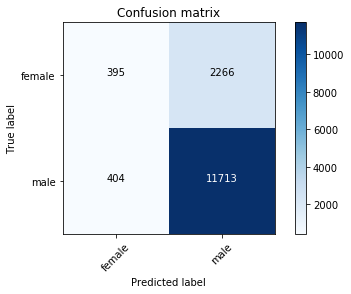

In [26]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [27]:
%%time
fr=RandomForestClassifier(n_estimators=150, min_samples_split=5, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 50.8 s, sys: 764 ms, total: 51.6 s
Wall time: 4.39 s


0.819935038571
0.83089727974
Confusion matrix, without normalization
[[  178  2483]
 [   16 12101]]


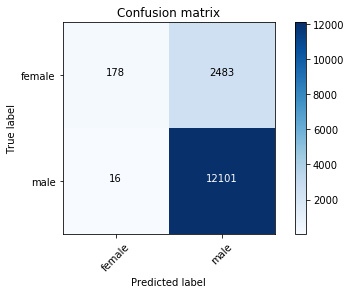

In [28]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [29]:
%%time
fr=RandomForestClassifier(n_estimators=640, min_samples_split=4, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3min 36s, sys: 1.08 s, total: 3min 37s
Wall time: 12.5 s


0.819935038571
0.832182974692
Confusion matrix, without normalization
[[  198  2463]
 [   17 12100]]


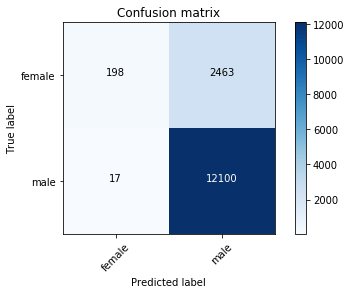

In [30]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [31]:
def plotting(model, df, num):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="g", xerr=std[indices][:num], 
            align="center", alpha=.7)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(df.shape[1]):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))

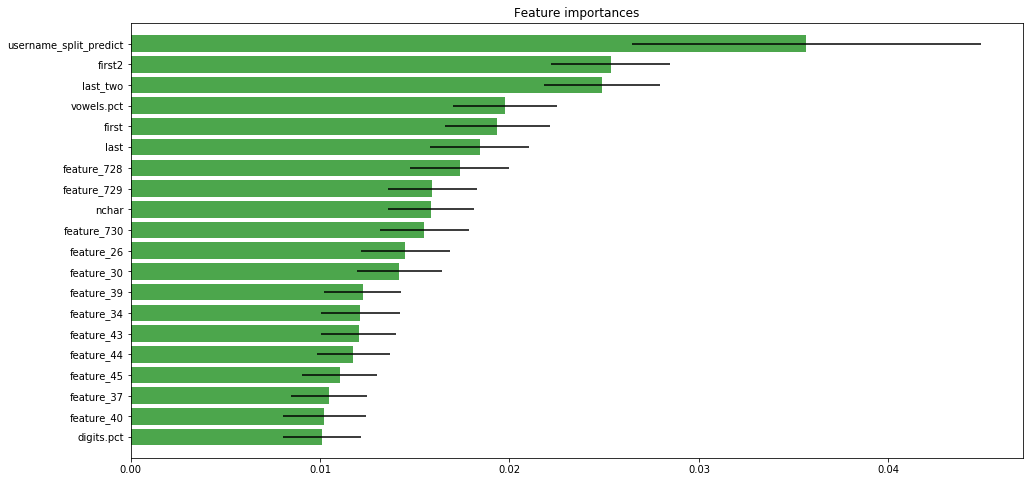

Feature ranking:
1. feature username_split_predict (3.57 %)
2. feature first2 (2.53 %)
3. feature last_two (2.49 %)
4. feature vowels.pct (1.98 %)
5. feature first (1.94 %)
6. feature last (1.84 %)
7. feature feature_728 (1.74 %)
8. feature feature_729 (1.59 %)
9. feature nchar (1.59 %)
10. feature feature_730 (1.55 %)
11. feature feature_26 (1.45 %)
12. feature feature_30 (1.42 %)
13. feature feature_39 (1.22 %)
14. feature feature_34 (1.21 %)
15. feature feature_43 (1.20 %)
16. feature feature_44 (1.18 %)
17. feature feature_45 (1.10 %)
18. feature feature_37 (1.05 %)
19. feature feature_40 (1.02 %)
20. feature digits.pct (1.01 %)
21. feature feature_38 (0.95 %)
22. feature feature_28 (0.94 %)
23. feature feature_29 (0.80 %)
24. feature feature_33 (0.79 %)
25. feature feature_0 (0.76 %)
26. feature digits.num (0.75 %)
27. feature feature_4 (0.72 %)
28. feature feature_27 (0.72 %)
29. feature feature_46 (0.71 %)
30. feature feature_36 (0.68 %)
31. feature feature_32 (0.68 %)
32. featu

In [32]:
plotting(fr, X_train, 20)

In [33]:
# RandomForestClassifier?

In [34]:
%%time
fr=RandomForestClassifier(n_estimators=200
                          , min_samples_split=6, n_jobs=24, criterion='entropy')
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 1min 3s, sys: 371 ms, total: 1min 4s
Wall time: 5.17 s


0.819935038571
0.831641629449
Confusion matrix, without normalization
[[  190  2471]
 [   17 12100]]


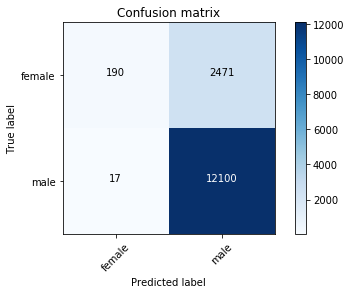

In [35]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

0.370347814319
Confusion matrix, without normalization
[[2015  646]
 [8659 3458]]


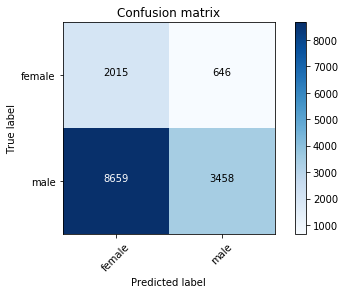

CPU times: user 8.61 s, sys: 2.56 s, total: 11.2 s
Wall time: 8.42 s


In [36]:
%%time
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm_pr=lsvm.predict(X_test)
pd.Series(lsvm_pr).value_counts()
print accuracy_score(y_test, lsvm_pr)
plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [37]:
import xgboost as xgb

/home/shj16110/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

In [39]:
d_train.get_label()

array([ 0.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

In [1]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':24,
    
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

NameError: name 'd_train' is not defined

In [42]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.851836	test-acc:0.803018
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 100 rounds.
[20]	train-acc:0.868366	test-acc:0.828394
[40]	train-acc:0.881097	test-acc:0.82995
[60]	train-acc:0.898904	test-acc:0.831033
[80]	train-acc:0.921002	test-acc:0.831439
[100]	train-acc:0.938577	test-acc:0.833198
[120]	train-acc:0.954469	test-acc:0.834348
[140]	train-acc:0.966533	test-acc:0.834822
[160]	train-acc:0.976625	test-acc:0.835093
[180]	train-acc:0.983673	test-acc:0.834484
[200]	train-acc:0.989241	test-acc:0.835363
[220]	train-acc:0.993707	test-acc:0.835837
[240]	train-acc:0.995708	test-acc:0.835431
[260]	train-acc:0.996868	test-acc:0.834754
[280]	train-acc:0.997709	test-acc:0.83489
[300]	train-acc:0.998637	test-acc:0.833536
Stopping. Best iteration:
[210]	train-acc:0.991619	test-acc:0.83604



'!!! used 67.24 s'

accuracy 0.834145351198
statistic
male      14206
female      572
dtype: int64
Confusion matrix, without normalization
[[  391  2270]
 [  181 11936]]


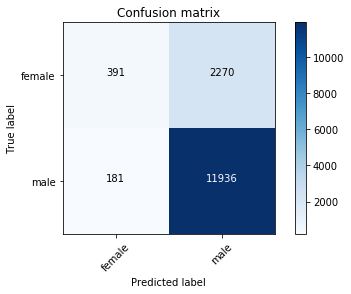

In [43]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

#### on accuracy 

### tune

In [44]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [45]:
y_train.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64

In [46]:
6210.0/28272

0.21965195246179967

In [47]:
RANDOM_STATE = 2017

params = {
    'min_child_weight': 0.8,
#     'eta': 0.1,
    'colsample_bytree': 0.8,
    'max_depth': 28,
    'subsample': 0.8,
    'alpha': 2,
    'lambda':3,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12,
        'max_delta_step ':7,
        'colsample_bylevel ':0.9 ,    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [48]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=200, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.838379	test-acc:0.820476
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 200 rounds.
[20]	train-acc:0.842121	test-acc:0.825281
[40]	train-acc:0.842092	test-acc:0.825551
[60]	train-acc:0.843542	test-acc:0.826025
[80]	train-acc:0.845253	test-acc:0.826161
[100]	train-acc:0.847834	test-acc:0.826567
[120]	train-acc:0.849922	test-acc:0.827446
[140]	train-acc:0.852503	test-acc:0.828597
[160]	train-acc:0.854301	test-acc:0.828529
[180]	train-acc:0.855606	test-acc:0.829003
[200]	train-acc:0.856882	test-acc:0.8288
[220]	train-acc:0.858216	test-acc:0.828732
[240]	train-acc:0.860072	test-acc:0.8288
[260]	train-acc:0.861522	test-acc:0.829273
[280]	train-acc:0.862972	test-acc:0.829679
[300]	train-acc:0.864422	test-acc:0.829612
[320]	train-acc:0.865582	test-acc:0.828935
[340]	train-acc:0.867902	test-acc:0.829206
[360]	train-acc:0.870106	test-acc:0.829476
[380]	train-acc:0.872426	test-acc:0.829679
[400]	tr

'!!! used 363.66 s'

accuracy 0.835904723237
statistic
male      14172
female      606
dtype: int64
Confusion matrix, without normalization
[[  421  2240]
 [  185 11932]]


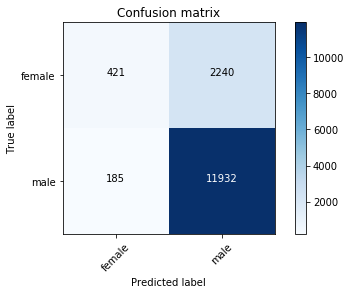

In [49]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [50]:
f_ip = pd.DataFrame(clf.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
f_ip.head(10)

,feature,importance
286,first2,58737
141,last_two,57415
367,vowels.pct,43475
426,last,34727
261,first,28113
517,feature_728,26093
429,nchar,24514
516,feature_729,24143
55,feature_26,23848
528,feature_30,23842


In [51]:
# pd.DataFrame.plot?

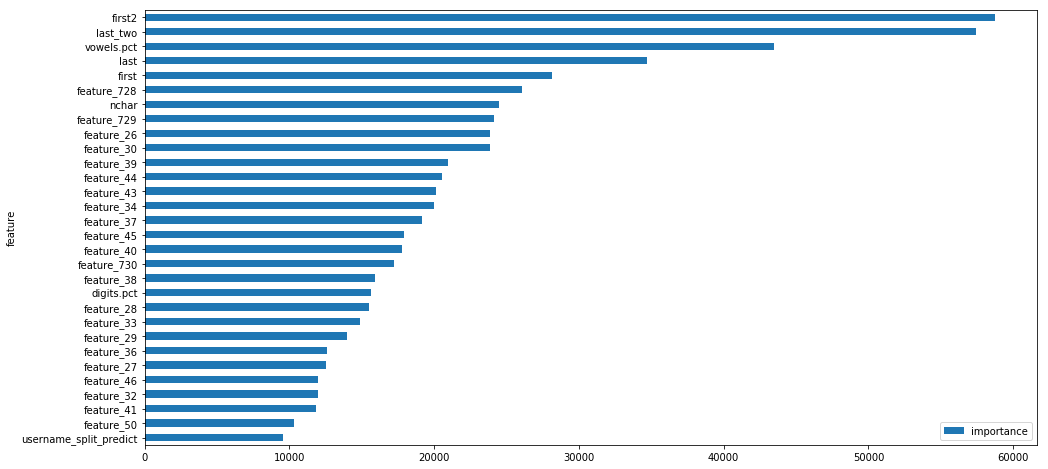

In [52]:
f_ip.head(30).iloc[::-1].set_index('feature').plot(kind='barh', figsize=(16,8))
plt.show()

In [53]:
pre0 = pre1.copy()
pre0.head(3)

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,female,okbookman


### other sklearn models

In [54]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()
# print accuracy_score(y_test, lsvm_pr)
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [55]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [56]:
# svm = SVC()
# svm

In [57]:
# %%time
# # svm.fit(X_train, y_train)

In [58]:
# from sklearn.neural_network import MLPClassifier

In [59]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [60]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [61]:
# pd.Series(neur_prd).value_counts()

In [62]:
# accuracy_score(y_test,neur_prd)

In [63]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [64]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [65]:
# pd.Series(pred).value_counts()

In [66]:
# accuracy_score(y_test, pred)

In [67]:
# confusion_matrix(y_test,pred)

In [68]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [69]:
# from sklearn.naive_bayes import BernoulliNB

In [70]:
# nb = BernoulliNB()
# nb

In [71]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()